In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(linewidth=200) # Sets message printing width for easier readability

In [2]:
#-- Boolean flags to change options --#
CONVERTPARAMS = True # Converts parameters of multinest scan to ones we would like to plot
EXPBOUNDS     = True
DEBUG         = True

# NOTE: This notebook assumes 2d scan in fpi_pow and bsmall_pow, do more general case later

In [3]:
#-- Option parameters, here for convenience --#
txtFilename='prelim_scan2/ULSNEST.txt'

# Load data from multinest scan

In [4]:
#-- Open data file --#
df = np.loadtxt(txtFilename, dtype=np.double)

posterior  = df[:,0]
likelihood = df[:,1]
fpi_pow    = df[:,2] # log_10(fpi/GeV)
bsmall_pow = df[:,3] # log_10(bsmall)

if(DEBUG):
    print("   posterior,        likelihood,        fpi_pow,      bsmall_pow")
    print(df[0:5,:])

   posterior,        likelihood,        fpi_pow,      bsmall_pow
[[ 1.05420808e-99  4.49812662e+02  4.39694467e+00 -2.76950246e+00]
 [ 2.02667869e-99  4.48500445e+02  4.65731375e+00 -3.15786721e+00]
 [ 2.43180110e-99  4.48130977e+02  4.62877653e+00 -3.38329113e+00]
 [ 2.61802260e-99  4.47978403e+02  4.67695287e+00 -2.98945338e+00]
 [ 9.21271241e-99  4.45457073e+02  4.62967646e+00 -3.37449723e+00]]


# Convert parameters to those we want to plot

Jacobian for a transformation from $x_1,...,x_n \rightarrow y_1,...,y_n$ is defined as 

$J = |\frac{\partial(y_1,...,y_n)}{\partial(x_1,...,x_n)}|$

then

$ d y_1...d y_n = J d x_1...d x_n$ 

Therefore the posterior $p(x | z)$ where $z$ is the data and $x$ are the parameters transforms to $p(y | z) = J p(x | z)$. 

And the likelihood $p(z | x)$ to $p(z | y) = J p(z | x)$. 

https://mathworld.wolfram.com/Jacobian.html

There are 3 possible cases enumerated below.

##### Case 1: If plotting in log_10 still
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD_pow, fpi_pow $\}$ where mD_pow $= {\rm log}_{10}(4 \pi) +$ fpi_pow $+$ bsmall_pow

##### Case 2: If NOT plotting in log_10
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD, fpi (GeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}}$

##### Case 3: If NOT plotting in log_10 and want fpi in TeV
- $x = \{$ bsmall_pow, fpi_pow$\}$
- $y = \{$ mD, fpi (TeV)$\}$ where mD $= 4 \pi 10.^{{\rm fpi \_ pow}} 10.^{{\rm bsmall \_ pow}}$ and fpi $= 10.^{{\rm fpi \_ pow}-3}$

In [5]:
if(CONVERTPARAMS):
    #########################################################
    ### Transform data -- Case 1: If plotting in log_10 still
    #########################################################
    # # In this case the jacobian is 1 so no transformation of probabilities is required
    # mD_pow = np.log10(4.*np.pi) + fpi_pow + bsmall_pow # log_10(mD/GeV)

    # # Create new df
    # df_new = np.column_stack((posterior, likelihood, fpi_pow, mD_pow))

    #########################################################
    ### Transform data -- Case 2: If NOT plotting in log_10
    #########################################################
    # # In this case the jacobian is NOT 1 so transformation of probabilities is required
    # fpi    = 10.**(fpi_pow) #fpi in GeV 
    # bsmall = 10.**bsmall_pow
    # mD     = 4.*np.pi*fpi*bsmall

    # # Calculate Jacobian i.e. |\partial(fpi, mD)/\partial(fpi_pow, bsmall_pow)|
    # J = (4*np.pi)*(np.log(10)**2)*(fpi**2)*bsmall

    # # Transform posterior and likelihood by multiplying by J
    # posterior_new  = J*posterior
    # likelihood_new = J*likelihood

    # # Create new df
    # df_new = np.column_stack((posterior_new, likelihood_new, fpi, mD))

    ###########################################################################
    ### Transform data -- Case 3: If NOT plotting in log_10 and want fpi in TeV
    ###########################################################################
    # In this case the jacobian is NOT 1 so transformation of probabilities is required
    fpi    = (10.**-3)*10.**(fpi_pow) #fpi in TeV
    bsmall = 10.**bsmall_pow
    mD     = 4.*np.pi*(10.**3)*fpi*bsmall

    # Calculate Jacobian i.e. |\partial(fpi, mD)/\partial(fpi_pow, bsmall_pow)|
    J = (4*np.pi)*(10**3)*(np.log(10)**2)*(fpi**2)*bsmall

    # Transform posterior and likelihood by multiplying by J
    posterior_new  = J*posterior
    likelihood_new = J*likelihood

    # Create new df
    df_new = np.column_stack((posterior_new, likelihood_new, fpi, mD))
else:
    posterior_new = posterior

# Estimate posterior PDF via weighted KDE estimate

In [6]:
from scipy import stats
values = np.vstack([mD, fpi])
kernel = stats.gaussian_kde(values, weights=posterior_new) 
# kernel is now a function which approximates our posterior PDF

### Evaluate posterior PDF estimate on grid for plotting and evaluation

In [7]:
#-- Define xy range (will also be used as image range) --#
xmin = mD.min()
xmax = mD.max()
ymin = 30 #fpi.min()
ymax = 45 #fpi.max()
print(xmin, xmax, ymin, ymax)

#-- Make meshgrid --#
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j] # 100x100 grid
positions = np.vstack([X.ravel(), Y.ravel()])
#print(X.shape, Y.shape)

#-- Evaluate kernel on meshgrid --#
Z = np.reshape(kernel(positions).T, X.shape) # 100x100 grid of PDF values, one for each XY point
#print(Z.shape)

89.62692912351645 1857.1027244701118 30 45


In [8]:
print(fpi.min(), fpi.max())

21.679322218456406 50.06409839697919


# Calculate 1 and 2 sigma contours

Calculates critical probability alpha such that $\int_{p(x,y) \geq p_{crit}} p(x,y) dx dy = 1 - \alpha$.

Where $\alpha = 0.32 \rightarrow 1 \sigma$ and $\alpha = 0.05 \rightarrow 2 \sigma$.

In [9]:
from numpy import ma
from scipy.optimize import bisect

In [10]:
# See https://github.com/michaelhb/superplot/blob/master/superplot/statslib/two_dim.py
def calcCriticalDensity(pdf, alpha):
    
    # Normalize posterior pdf so that integral is one, if it wasn't already
    pdf = pdf / pdf.sum()
    
    # Minimize difference between amount of probability contained above a
    # particular density and that desired
    prob_desired = 1. - alpha

    def prob_contained(density):
        return ma.masked_where(pdf < density, pdf).sum()

    def delta_prob(density):
        return prob_contained(density) - prob_desired

    # Critical density cannot be greater than maximum posterior pdf and must
    # be greater than 0. The function delta_probability is monotonic on that
    # interval. Find critical density by bisection.
    critical_density = bisect(delta_prob, 0., pdf.max())

    return critical_density

In [11]:
#-- Make sure pdf is normalized properly --#
pdf = Z
pdf = pdf/pdf.sum()

#-- Define alpha levels --#
# NOTE: Do more general version later
levels = [2, 1] # Number of sigma for contour, list in descending order
alpha = np.zeros(len(levels))

for i in range(len(levels)):
    l = levels[i]
    if l==1:
        alpha[i] = 0.32 #=> 68% probability contained
    elif l==2:
        alpha[i] = 0.05 #=> 95% probability contained
    
#-- Calculate critical density --#
critDensity = []
for aa in alpha:
    critDensity.append(calcCriticalDensity(pdf, aa))
    
print(critDensity)

[0.00011720454592738076, 0.0005295628174902785]


# Define experimental bounds

In [12]:
LHC_bound = 420 # m_chi GeV #https://arxiv.org/pdf/1908.08215.pdf and https://arxiv.org/pdf/1807.07799.pdf

# Plot everything

In [13]:
#-- Quick function to convert human RGBA to python RGBA tuple format --#
def RGBAtoRGBAtuple(color):
    r = color[0]/255
    g = color[1]/255
    b = color[2]/255
    a = color[3]
    return (r, g, b, a)

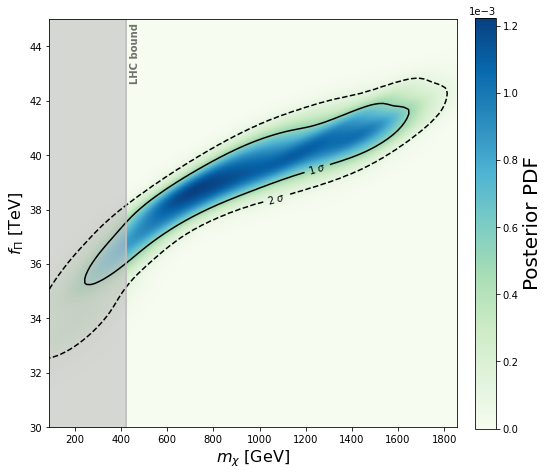

In [32]:
fig, ax = plt.subplots(figsize=(8,8))

#-------------------------------------------------#
#-- Make the contours of the critical densities --#
#-------------------------------------------------#

pdf = Z/Z.sum() # Normalize
CS = ax.contour(X, Y, pdf, levels=critDensity, colors=['black', 'black'], linestyles = ['--', '-']) 

#---------------#
#-- Make plot --#
#---------------#

# Set plot limits 
plotLims = [xmin, xmax, ymin, ymax]

# Set the aspect so that resulting figure is a square
aspect = (plotLims[1] - plotLims[0]) / (plotLims[3] - plotLims[2])

# Make plot
im1 = ax.imshow(np.rot90(pdf), cmap='GnBu', aspect=aspect, extent=plotLims, interpolation='bilinear')

#---------------#
#-- Fix stlye --#
#---------------#

# Set plot limits
ax.set_xlim([plotLims[0], plotLims[1]])
ax.set_ylim([plotLims[2], plotLims[3]])

# Add labels to contours
fmt = {}
strs = [r'2 $\sigma$',r'1 $\sigma$']
for l, s in zip(CS.levels, strs):
    fmt[l] = s
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

# Plot colorbar and add lables
cb = plt.colorbar(im1, orientation='vertical', fraction=0.046, pad=0.04)
cb.set_label('Posterior PDF', size=20)
cb.formatter.set_powerlimits((0, 0))

# Set x and y axis labels
ax.set(xlabel=r'$m_\chi$ [GeV]', ylabel=r'$f_\Pi$ [TeV]')
ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(16)


#---------------------------#
#-- Add experiment bounds --#
#---------------------------#
if(EXPBOUNDS):
    plt.plot([LHC_bound, LHC_bound], [plotLims[2], plotLims[3]], color=RGBAtoRGBAtuple((191,191,191,1)))  
    plt.fill_between([plotLims[0], LHC_bound], [plotLims[2], plotLims[2]], [plotLims[3], plotLims[3]], color=RGBAtoRGBAtuple((191,191,191,0.6)))
    plt.text(LHC_bound+20, plotLims[3]-2.3, 'LHC bound', rotation=90, color=RGBAtoRGBAtuple((112,112,112,1)), fontweight='bold')

plt.show()